<a href="https://colab.research.google.com/github/ShimitaRudra/DeepLearning_MoviePosters/blob/main/MoviePoster_yearPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CT5133 / CT5145 Deep Learning (/Online) 2022-2023

## James McDermott

* Student ID: 22221035
* Student name: Shimita Rudra

**Due date**: midnight Sunday 19 March (end Week 10).

**Weighting**: 20% of the module.

The goal is to take advantage of pre-trained NN models to create an embedding with a dataset of movie posters, and demonstrate how to use that embedding.

The dataset is provided, along with some skeleton code for loading it.

The individual steps to be carried out are specified below, with markers, together with the number of marks available for each part.

* **Topics**: in Part 5 below, students are asked to add some improvement to their models. In general, these improvements will differ between students (or student groups). **The proposed improvement must be notified to the lecturer at least 1 week before submission, and approved by the lecturer**. If working in a group, the two members of the group should not work on different topics in Part 5: they must work on the same topic and submit identical submissions.

* Students are not required to work incrementally on the parts. It is ok to do all the work in one day, so long as you abide by the rules on notifying groups and notifying topics.

* **Groups**: students may work solo or in a group of two. A student may not work together in a group with any student they have previously worked on a group project with, in this module or any other in the MSc programme. **Groups must be notified to the lecturer in writing before beginning work and at least 1 week before submission.** If working in a group, both students must submit and both submissions must be identical. If working in a group, both students may be asked to explain any aspect of the code in interview (see below), therefore working independently on separate components is not recommended. Any emails concerning the project should be cc-ed to the other group member.

* **Libraries**: code can be written in Keras/Tensorflow, or in PyTorch.

* **Plagiarism**: students may discuss the assignment together, but you may not look at another student or group's work or allow other students to view yours (other than within a group). You may use snippets of code (eg 1-2 lines) from the internet, **if you provide a citation with URL**. You may also use a longer snippet of code if it is a utility function, again only with citation. You may not use code from the internet to carry out the core of the assignment. You may not use a large language model to generate code.

* **Submission**: after completing your work in this Jupyter notebook, submit the notebook both in `.ipynb` and `.pdf` formats. The content should be identical.

* **Interviews**: a number of students may be selected for interview, post-submission. The selection will depend on submissions, and random chance may be used also. Interviews will be held in-person (CT5133) or online (CT5145). Interviews will last approximately 10 minutes. The purpose of interviews will be to assess students' understanding of their own submission.


### Dataset Credits

The original csv file is from:

https://www.kaggle.com/datasets/neha1703/movie-genre-from-its-poster

I have added the *year* column for convenience.

I believe most of the information is originally from the famous MovieLens dataset:

* https://grouplens.org/datasets/movielens/
* https://movielens.org/

However, I'm not clear whether the poster download URLs (Amazon AWS URLs) which are in the csv obtained from the Kaggle URL above are from a MovieLens source, or elsewhere.

To create the dataset we are using, I have randomly sampled a small proportion of the URLs in the csv, and downloaded the images. I have removed those which fail to download. Code below also filters out those which are in black and white, ie 1 channel only.

### Imports

You can add more imports if needed.

In [ ]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, pdist, squareform # useful for distances in the embedding

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models

In [ ]:
#Added this import for warnings
import warnings #Ref 13
warnings.filterwarnings('ignore', category=FutureWarning)

### Utility functions

These functions are provided to save you time. You might not need to understand any of the details here.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/'

image_path = path + 'DL_Sample/'

In [ ]:
# walk the directory containing posters and read them in. all are the same shape: (268, 182).
# all have 3 channels, with a few exceptions (see below).
# each is named <imdbId>.jpg, which will later allow us to get the metadata from the csv.
IDs = []
images = []
for dirname, _, filenames in os.walk(image_path):
    for filename in filenames:
        if filename.endswith(".jpg"):
            ID = int(filename[:-4])
            pathname = os.path.join(dirname, filename)
            im = Image.open(pathname)
            imnp = np.array(im, dtype=float)
            if len(imnp.shape) != 3: # we'll ignore a few black-and-white (1 channel) images
                print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue # do not add to our list
            IDs.append(ID)
            images.append(imnp)

In [ ]:
img_array = np.array(images)

In [ ]:
img_array.shape

(1238, 268, 182, 3)

In [ ]:
# read the csv
df = pd.read_csv("Movie_Genre_Year_Poster.csv", encoding="ISO-8859-1", index_col="Unnamed: 0")
df.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster,Year
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...,1995.0
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...,1995.0
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0


In [ ]:
df2 = df.drop_duplicates(subset=["imdbId"]) # some imdbId values are duplicates - just drop

In [ ]:
df3 = df2.set_index("imdbId") # the imdbId is a more useful index, eg as in the next cell...

In [ ]:
df4 = df3.loc[IDs] # ... we can now use .loc to take a subset

In [ ]:
df4.shape # 1238 rows matches the image data shape above

(1238, 6)

In [ ]:
df4.head()

,Imdb Link,Title,IMDB Score,Genre,Poster,Year
imdbId,,,,,,
203425,http://www.imdb.com/title/tt203425,Crocodile (2000),3.7,Horror|Thriller,https://images-na.ssl-images-amazon.com/images...,2000.0
80905,http://www.imdb.com/title/tt80905,Clan of the White Lotus (1980),7.5,Action|Drama,https://images-na.ssl-images-amazon.com/images...,1980.0
338075,http://www.imdb.com/title/tt338075,Grand Theft Parsons (2003),6.1,Adventure|Comedy|Drama,https://images-na.ssl-images-amazon.com/images...,2003.0
1352388,http://www.imdb.com/title/tt1352388,Nude Nuns with Big Guns (2010),3.9,Action|Comedy|Thriller,https://images-na.ssl-images-amazon.com/images...,2010.0
3312936,http://www.imdb.com/title/tt3312936,LA Apocalypse (2015),2.5,Action|Sci-Fi|Thriller,https://images-na.ssl-images-amazon.com/images...,2015.0


In [ ]:
years = df4["Year"].values
titles = df4["Title"].values

assert img_array.shape[0] == years.shape[0] == titles.shape[0]
assert all(np.isfinite(years)) # no missing values in years
print(years.min(), years.max())

1888.0 2016.0


In [ ]:
def imread(filename):
    """Convenience function: we can supply an ID or a filename.
    We read and return the image in Image format.
    """

    if type(filename) == int:
        # assume its an ID, so create filename
        filename = f"{image_path}{filename}.jpg"

    # now we can assume it's a filename, so open and read
    im = Image.open(filename)

    return im

def imshow(im):
    plt.imshow(im)
    plt.axis('off')

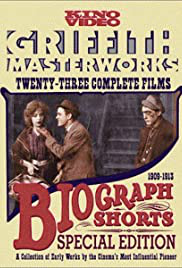

In [ ]:
imread(2795) #just for checking

### Part 1. Create embedding [3 marks]

Use a pretrained model, eg as provided by Keras, to create a flat (ie 1D) embedding vector of some size `embedding_size` for each movie poster, and put all of these together into a single tensor of shape `(n_movies, embedding_size)`.

> Using the pretrained model VGG19 to get a flat embedding vector of the size `20480` for each of the `1238` images. Hence we observe that the shape of the embeddings is `(1238, 20480)`. The VGG19 is a very deep convolutional nueral networks used for computer vision or image recognition which is a large scale deep Nueral net model consisting of many convolution layers and max pooling layers. It has been trained previoualy on a huge dataset i.e imagenet dataset. Since, VGG19 has worked on many images, it has basically been trained on various features that are useful in recognizing other image datasets as well. The 19 at the end of VGG19 ndicate the number of deep layers in the pre-trained model *(#Ref 2, 14)*.

> In our implementation of the pre-trained model,
1. we are using our movie-poster image array dataset having 1238 images with the size of `268 x 182` and `3 channels` each
2. Since the model has been pretrained on the `imagenet` dataset, we are going to utilize the same weights for prediction on the new dataset as well.
3. As we will require our own outputs, we donot include the top layer (Output layer), we will add our own output layer into the model that will recognize the movie posters.
4. To fix the weights & bias of layers of pretrained model, we have set each of them to `trainable = False`

> Created a Sequential model and added the pretrained model to it, and then added a `Flatten` layer. Preprocessed the input before passing the image array through the model to give the embeddings (X) of the movie posters.

> On checking the shape of X, it gives us the correct value of `n_movies, embedding_size` i.e `(1238, 20480)`

In [ ]:
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.layers import Dense, Flatten, Dropout, Conv2D,GlobalAveragePooling2D

In [ ]:
n_movies = img_array.shape[0]
embedding_size = 20480 # YOUR CODE HERE
X = tf.zeros((n_movies, embedding_size))

### YOUR CODE HERE
pretrained_model = VGG19(input_shape = img_array.shape[1:],weights = 'imagenet', include_top = False) #Ref 2

for layer in pretrained_model.layers: #Ref 3
  layer.trainable = False

model = keras.Sequential()
model.add(pretrained_model) #Ref 15
model.add(Flatten())
preprocess_img_array = preprocess_input(img_array)
X = model.predict(preprocess_img_array)

assert len(X.shape) == 2 #X should be (n_movies, embedding_size)
assert X.shape[0] == n_movies

In [ ]:
#img_array.shape[1:]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 5, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
Total params: 20,024,384
Trainable params: 0
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
X.shape

(1238, 20480)

### Part 2. Define a nearest-neighbour function [3 marks]

Write a function `def nearest(img, k)` which accepts an image `img`, and returns the `k` movies in the dataset whose posters are most similar to `img` (as measured in the embedding), ranked by similarity.

> k NN function written below using cdist _(#Ref 5)_.
1. Each image is converted to an np array `(height, width, channels)`,
2. Then Pre-processed and converted into a `(batch, height, width, channels)` in this case batch is 1 since there is one input image
3. The image can now be passed through the model for prediction and then receive an embedding of that target image
4. Using cdist finding the distance w.r.t the target image embedding and all the embeddings (X) found previously in Part 1 using Euclidean distance.
5. Sorted the dist array to get the indices of the nearest k images (leaving the target image from the dist array (leaving out index 0) and returning the top k image indices in an array

In [ ]:
def k_nearest(img, k, embedding, model):
    ### YOUR CODE HERE
    img_1_array = np.array(img)
    preprocess_img = preprocess_input(img_1_array)
    preprocess_img = np.array([preprocess_img])
    img_embedding = model.predict(preprocess_img)
    dist = cdist(img_embedding, embedding,  metric = 'euclidean') #Ref 5
    sorted_dist = np.argsort(dist)
    indices_k = sorted_dist[:,1:k+1]

    return indices_k[0]

In [ ]:
#Ref 4
#Using a function to plot all the neighbouring movie posters
def show_images(image, title=''):
  plt.title(title, size=14), plt.imshow(image,cmap=plt.get_cmap('gray'),norm=None)
  plt.axis('off')

### Part 3: Demonstrate your nearest-neighbour function [4 marks]

Choose any movie poster. Call this the query poster. Show it, and use your nearest-neighbour function to show the 3 nearest neighbours (excluding the query itself). This means **call** the function you defined above.

Write a comment: in what ways are they similar or dissimilar? Do you agree with the choice and the ranking? Why do you think they are close in the embedding? Do you notice, for example, that the nearest neighbours are from a similar era?

> Choosen the Tintin moviee poster from 2011

> The posters are similar w.r.t colour gradient, as all the 4 posters seem to be having dark theme. Along with certain shiny (white pixels) elements in between the image which are contrasting to the overall dark background. Hence, the posters do seem **similar**

> Yes, I agree with these 3 nearest neighbours and the ranking as well. Considering the third ranked image has slightly low contrasting white and black pixels.

> The images are pretty much from the same era, somewhere close to the 21st century movies. The top 2 movies are from 2008 and 2014 respectively.  Considering the thrid poster whic is from 1999 is also closer to 2000 than to the main stream 20th century movies. Hence, the resemblance.


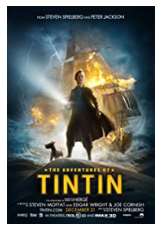

In [ ]:
### YOUR CODE HERE
Q_idx = 983193 # YOUR VALUE HERE - DO NOT USE MY VALUE
#imshow(imread(Q_idx))

img_tintin = imread(983193)
imshow(img_tintin)

1/1 [==============================] - 0s 52ms/step


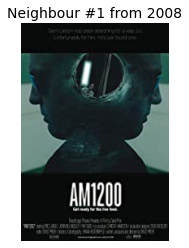

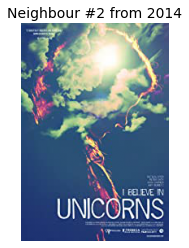

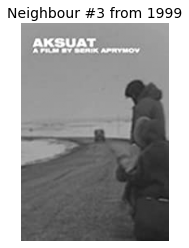

In [ ]:
nearest_tintin = k_nearest(img_tintin, 3, X, model) #embedding = X

for i,index in enumerate(nearest_tintin, start=1):
  plt.figure(figsize = (4,4))
  year = int(years[index])
  show_images(img_array[index]/255, 'Neighbour #' + str(i) + " from " + str(year))
plt.show()

### Part 4: Year regression [5 marks]

Let's investigate the last question ("similar era") above by running **regression** on the year, ie attempt to predict the year, given the poster. Use a train-test split. Build a suitable Keras neural network model for this, **as a regression head on top of the embedding from Part 1**. Include comments to explain the purpose of each part of the model. It should be possible to make a prediction, given a new poster (not part of the original dataset). Write a short comment on model performance: is it possible to predict the year? Based on this result, are there trends over time?

> Created a new nueral network sequential model which essentially behaves as the regression head for predicting years based on movie posters based on the embedding created in the Part 1
> By splitting the embedding dataset into Train(70%), Test(15%) and Validation(15%) dataset, we will ensure that the model trains on the training set and omproves using the validation set. The testing set will be brand new poster for the model and hence we will test if given a new poster the model is able to predict the year of the poster well or not.

> The model created is giving inaccurate results and a poor Mean Absolute error on compiling using Huber loss. Huber loss is well known for handling outliers. For this project, I haves used this loss function. Due to less amount of training and less numbers of images, there is underfitting in this model. And hence, it is difficult to realize any trends over time using this.

> **Details about the model**:

1. The sequential model has a dropout layer foloowed by a Dense Layer of 64 neurons using RELu activation function. Followed by another Dense Layer that has only 1 nueron for the final predictions that will be linearly predicted.
2. The model is compiled using Huber loss, Adam optimizer. Used Mean Absolute Error for checking the error
3. The model is then trained on `100 epochs` and `128 batch size`
4. On predicting the years for the Testing dataset, the model gives very poor results and the Mean Absolute error and the Huber loss are quite high. Indicating the predicted years and actual years have a average difference of 3 centuries (approximately)



In [ ]:
### YOUR CODE HERE
from sklearn.model_selection import train_test_split

nn_model = keras.Sequential()
nn_model.add(Dropout(0.2))
nn_model.add(Dense(64, activation='relu')) #Ref 6
nn_model.add(Dense(1, activation='linear'))

nn_model(X)
nn_model.compile(loss=tf.keras.losses.Huber(), optimizer="adam",
                 metrics=[tf.keras.losses.MeanAbsoluteError()]) # Ref 7,9,10

In [ ]:
X_Train, X_Test, y_train, y_test= train_test_split(X, years, test_size=0.3, random_state=22221035) # 70% - train
X_Val, X_Test, y_val, y_test= train_test_split(X_Test, y_test, test_size=0.5,
                                               random_state=22221035) # 15% - val, 15% - test

In [ ]:
nn_model.fit(X_Train, y_train, batch_size=128, epochs = 100, validation_data=(X_Val, y_val), verbose = 0) #Ref 8
nn_model.save("NN_model_Part4.saved_model")

In [ ]:
y_pred = nn_model.predict(X_Test)
y_pred = np.around(y_pred)

6/6 [==============================] - 0s 2ms/step


In [ ]:
score = nn_model.evaluate(X_Test, y_test, verbose=0)
print("Test Huber loss:", round(score[0],3))
print("Test Mean Absolute Error:", round(score[1],4))

Test Huber loss: 311.119
Test Mean Absolute Error: 313.9267


In [ ]:
nn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 64)                1310784   
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,310,849
Trainable params: 1,310,849
Non-trainable params: 0
_________________________________________________________________


### Part 5: Improvements [5 marks]

Propose a possible improvement. Some ideas are suggested below. The chosen improvement must be notified to the lecturer at least 1 week before submission and **must be approved by the lecturer to avoid duplication with other students**. Compare the performance between your original and your new model (the proposed improvement might not actually improve on model performance -- that is ok). Some marks will be awarded for more interesting / challenging / novel improvements.

Ideas:

* Try a different pretrained model for creating the embedding
* Alternative ways of reducing the pretrained model's output to a flat vector for the embedding
* Gather more data (see the csv file for URLs)
* Add different architectural details to the regression head
* Fine-tuning
* Training an end-to-end convnet of your own design (no pretraining)
* Improve the embedding by training a multi-headed model, eg predicting both genre and year
* Create a good visualisation of the embedding.

> On agreement with Prof J McDermott, I have used **_Fine tuning_** along with **_Alternative ways of reducing the pretrained model's output to a flat vector for the embedding_** using Global Average Pooling.
> It can be observed that the improvements to the model have resulted in much better results in comparison to Part 4. The Huber loss and the Mean Absolute Error both have reduced incredibly.
> Even the nearest neighbours for these embeddings are giving better results. On observing the years of top 3 posters, we can see that these posters are closer to the year of the target (Tintin movie) poster. i.e 2015,2016 and 2006
> **Details of the model:**
1. Kept the last 3 layers of the pretrained model as trainable, to further improve the feature of the movies poster dataset.
2. Fine tuning Using 3 more layers of Conv2D of 64, 32 and 16 neurons respectively and kept the padding to keep the size of the image as same.
3. Added a Global Average Pooling Layer that reduces the need to add Flatten, Dropout and Dense layers _(Ref 12)_. This gives us an embdding of size 16 which is much lesser than the Part 1 embedding
4. Also the regression head has been fine-tuned using more Dense layers than in Part 4
5. Batch size has been reduced to 32

In [ ]:
### YOUR CODE HERE
for layer in pretrained_model.layers[:16]: #Ref 3
  layer.trainable = False

new_model = keras.Sequential()
new_model.add(pretrained_model)
new_model.add(Conv2D(64, kernel_size=(3,3), padding = "same")) #Ref 11
new_model.add(Conv2D(32, kernel_size=(3,3), padding = "same"))
new_model.add(Conv2D(16, kernel_size=(3,3)))
new_model.add(GlobalAveragePooling2D()) #Ref 12
#preprocess_img_array = preprocess_input(img_array)
X_new = new_model.predict(preprocess_img_array)



39/39 [==============================] - 6s 153ms/step


In [ ]:
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 5, 512)         20024384  
                                                                 
 conv2d (Conv2D)             (None, 8, 5, 64)          294976    
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 5, 32)          18464     
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 3, 16)          4624      
                                                                 
 global_average_pooling2d (G  (None, 16)               0         
 lobalAveragePooling2D)                                          
                                                                 
Total params: 20,342,448
Trainable params: 318,064
Non-trainable params: 20,024,384
____________________________________

In [ ]:
X_new.shape

(1238, 16)

1/1 [==============================] - 0s 24ms/step


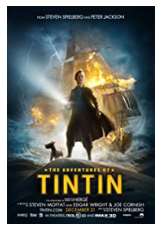

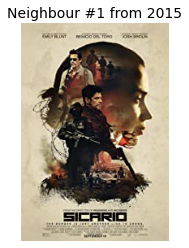

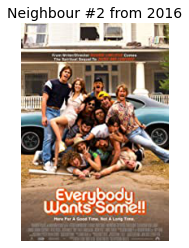

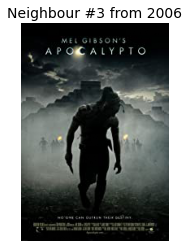

In [ ]:
img_tintin = imread(983193)
imshow(img_tintin)

nearest_tintin_new = k_nearest(img_tintin, 3, X_new, new_model) #embedding = X_new

for i,index in enumerate(nearest_tintin_new, start=1):
  plt.figure(figsize = (4,4))
  year = int(years[index])
  show_images(img_array[index]/255, 'Neighbour #' + str(i) + " from " + str(year))
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

nn_model_new = keras.Sequential()

nn_model_new.add(Dropout(0.5)) #changed dropout to 0.5
nn_model_new.add(Dense(128, activation='softmax')) #Ref 6
nn_model_new.add(Dense(64, activation='relu'))
nn_model_new.add(Dense(32, activation='relu'))
nn_model_new.add(Dense(1, activation='linear'))

nn_model_new(X_new)
nn_model_new.compile(loss=tf.keras.losses.Huber(), optimizer="adam",
                     metrics=[tf.keras.losses.MeanAbsoluteError()])

X_Train_new, X_Test_new, y_train_new, y_test_new= train_test_split(X_new, years, test_size=0.3,
                                                                   random_state=22221035) # 70% - train
X_Val_new, X_Test_new, y_val_new, y_test_new= train_test_split(X_Test_new, y_test_new, test_size=0.5,
                                                               random_state=22221035) # 15% - val, 15% - test

In [ ]:
nn_model_new.fit(X_Train_new, y_train_new, batch_size=32, epochs = 100,
                 validation_data=(X_Val_new, y_val_new), verbose =0) #Ref 8
nn_model_new.save("NN_model_Part5.saved_model")

In [ ]:
y_pred_new = nn_model_new.predict(X_Test_new)
y_pred_new = np.around(y_pred_new)

In [ ]:
score = nn_model_new.evaluate(X_Test_new, y_test_new, verbose=0)
print("Test Huber loss:", round(score[0],3))
print("Test Mean Absolute Error:", round(score[1],4))

Test Huber loss: 15.727
Test Mean Absolute Error: 16.2276


References:
1. Lecture notes by James McDermott

2. https://keras.io/api/applications/vgg/#vgg16-function
3. https://github.com/nachi-hebbar/Transfer-Learning-Keras/blob/main/TransferLearning.ipynb For loop trainable = False
4. Shimita_Rudra_22221035_Assignment 2 - Barcode.ipynb in EE551 Embedded image processing assignment 2 written by Shimita Rudra
5. https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
6. Choosing activations from the list of activations: https://keras.io/api/layers/activations/
7. https://keras.io/api/metrics/regression_metrics/
8. https://www.tensorflow.org/api_docs/python/tf/keras/Model
9. https://www.tensorflow.org/api_docs/python/tf/keras/metrics class MeanAbsoluteError
10. https://www.tensorflow.org/api_docs/python/tf/keras/losses class Huber
11. https://keras.io/api/layers/convolution_layers/convolution2d/
12. https://keras.io/api/layers/pooling_layers/global_average_pooling2d/
13. Runtime Warning disable https://www.codespeedy.com/how-to-disable-python-warnings/#:~:text=To%20disable%20warnings%20in%20Python%2C%20we%20can%20make%20use%20of,the%20warnings%20module%20in%20Python.
15. VGG-19 definition - https://uk.mathworks.com/help/deeplearning/ref/vgg19.html
16. Adding layers https://keras.io/guides/sequential_model/

## **Post Note** - Rendering the file to a pdf has spoiled the output images, please refer to .ipynb for the images of the nearest neighbours